# Data-driven approaches to understanding dementia
## Application of single cell analysis to dementia research: practical
### Mark Fiers & Emma Davis

## Goals

* Understand a single cell data analysis workflow
* Practically run a basic single cell workflow
* Understand where things can go wrong (and how to catch problems)
* Pointers on where to continue your analysis

## Outline 

- Introduction
- Finding & loading data
- Preprocessing & QA
- Dimensionality reduction & clustering
- Differential expression, finding marker genes
- Continuing the analysis
- Closing remarks

## Trust, But verify.

*or - a reflection on data analysis & bioinformatics*

* Treat all operations as 'black box'.
* Understand and check input & output.
* Once you have a result, confirm using raw data.
   * For example, you have gene X upregulated in elder microglia - go back to the raw counts, and independently check it is the case.


## How to get help?

- Tutorials (eg, [Scanpy tutorials](https://scanpy-tutorials.readthedocs.io/en/latest/))
- Your friendly neighbourhood bioionformatician
- chatGPT & friends
- Google
- Read API documentation (describing the functions in a package (eg, [Scanpy API](https://scanpy.readthedocs.io/en/latest/api/index.html))
- Fiddle around

## Conda / Mamba

We are running in a conda environment. Conda is a software package manager - allows you to maintain a consistent software environment. Mamba is it's interchangeable, but faster sister. [Read more on the Mamba documentation page](https://mamba.readthedocs.io/)

### Recreate this conda/mamba environment

```
# or mamba install
conda install -c conda-forge scanpy python-igraph leidenalg \
    jupyterlab seaborn scikit-learn statsmodels colorcet \
    scipy matplotlib jupyterlab jupyter_contrib_nbextensions \
    pooch
```

## Jupyter

We Will be using jupyter notebooks. Jupyter notebooks are environments that allow for easy sharing 

## Start our session

### First - go to your VM and open a terminal:

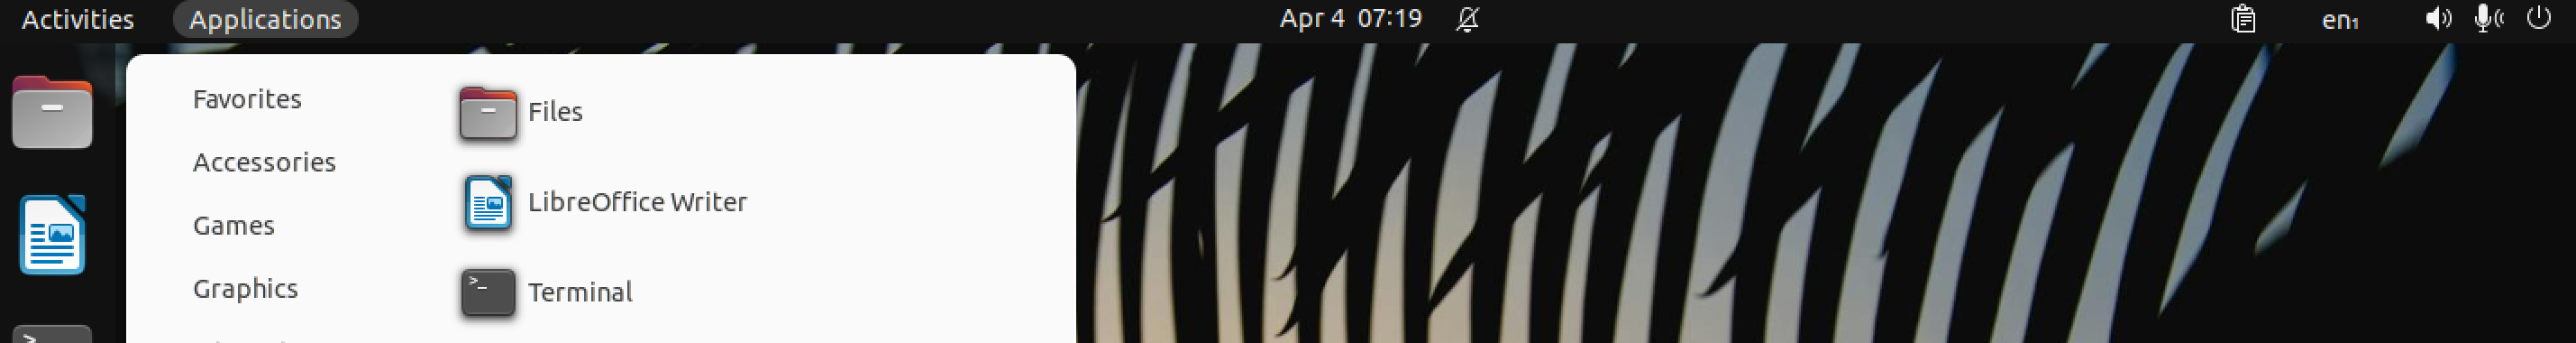

### Startup the environment

```
cd MF_SingleCell                 # Go to our work folder
./download_notebook.sh           # Download the ipython notebook
conda activate MF_SingleCell     # Start the conda environment
jupyter lab                      # Start jupyter lab
```

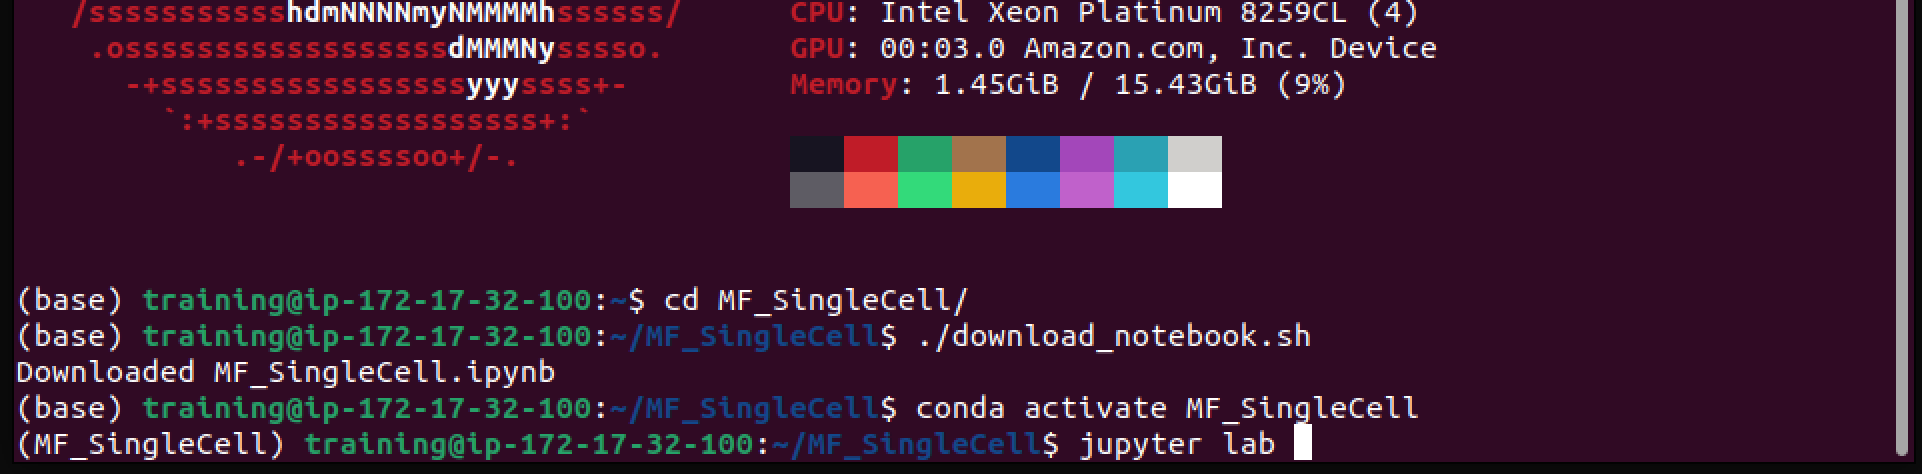

### Jupyter lab initial interface

*Maybe you need to click the `MF_SingleCell.ipynb` link on the left*

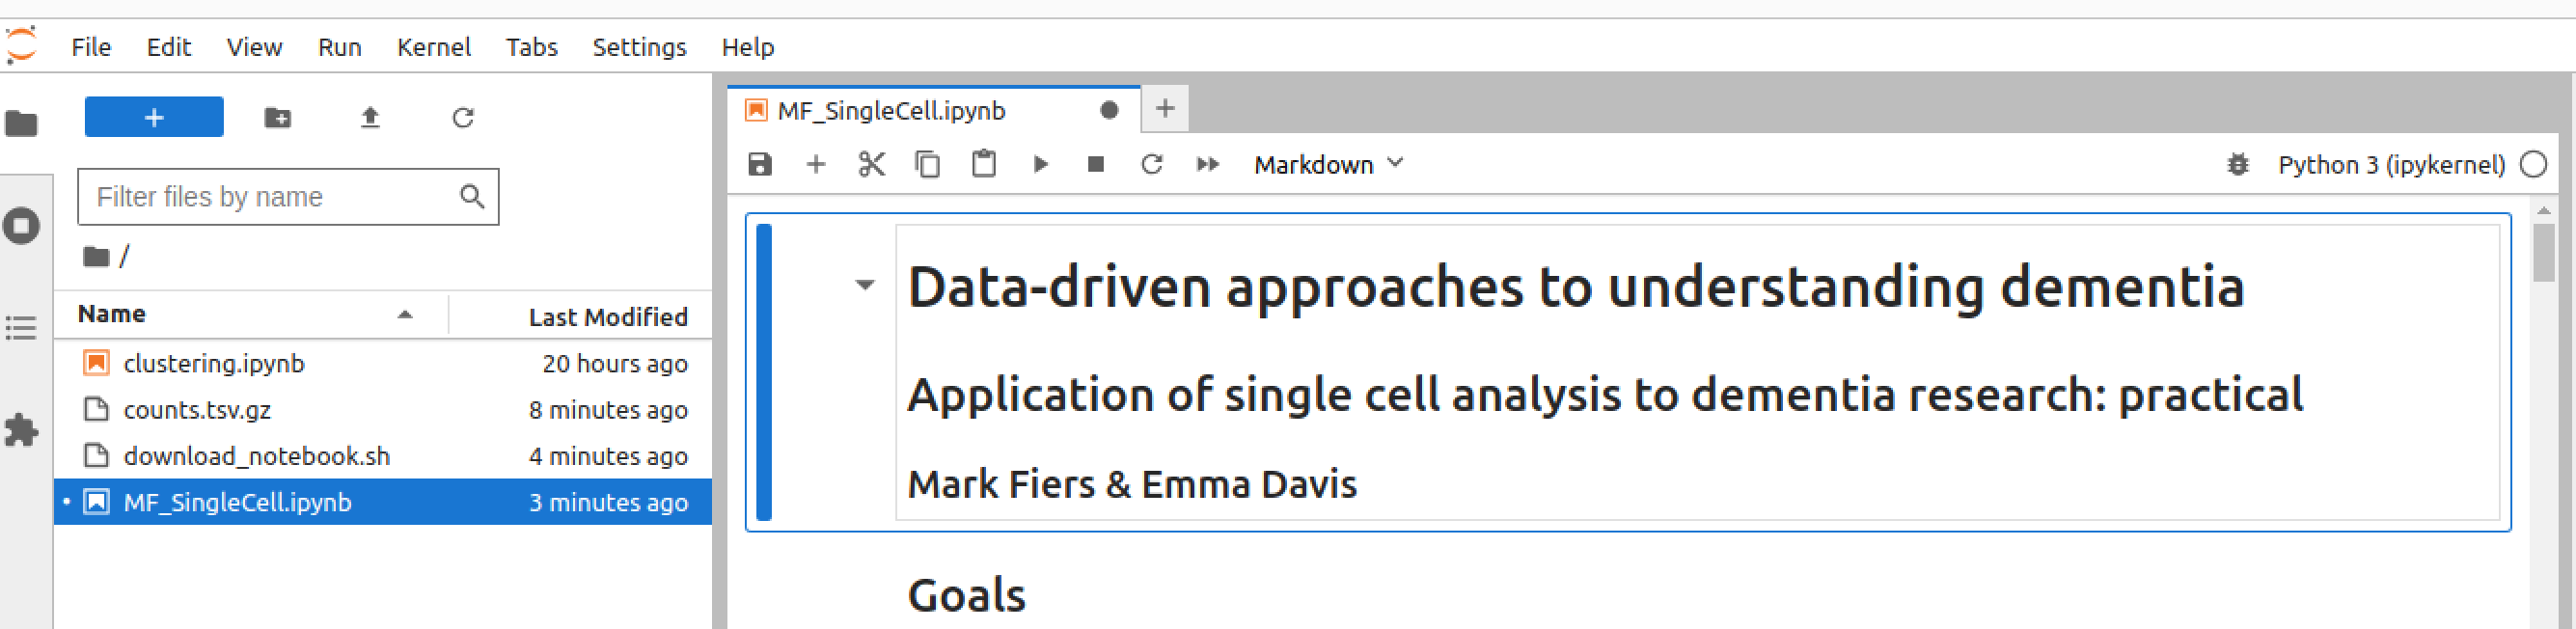

---

# Paper
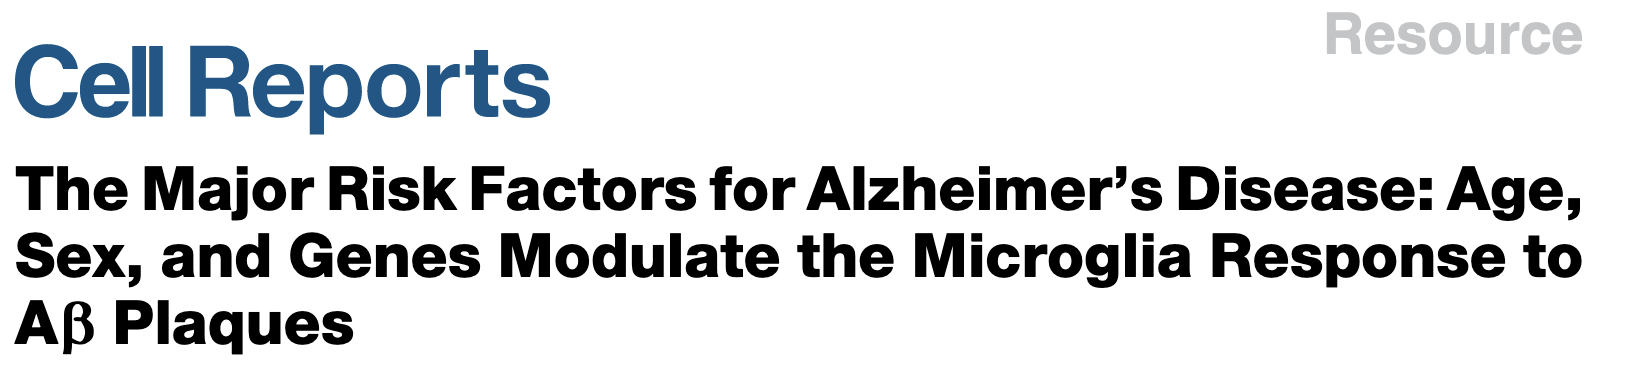


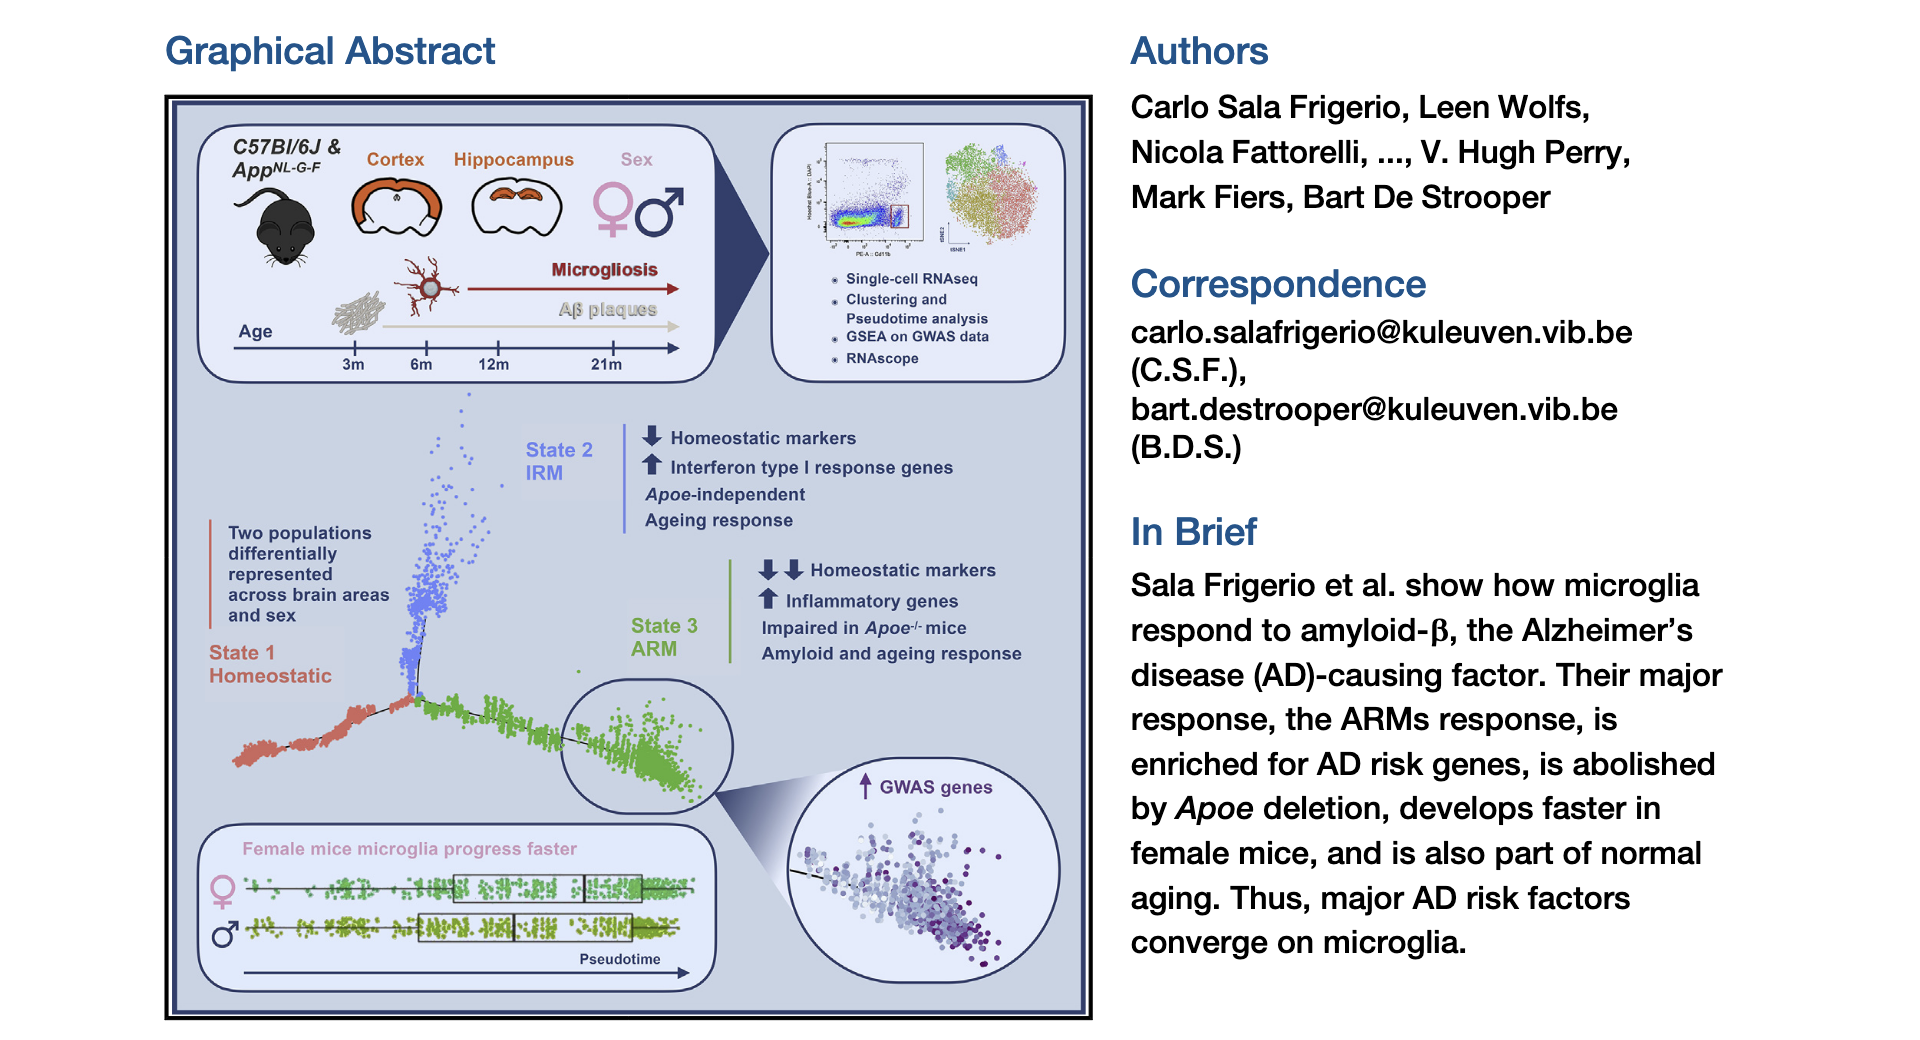

## Some reading

### General

* [Jupyter lab documentation](https://jupyterlab.readthedocs.io/en/stable/)
* [Scanpy documentation](https://scanpy.readthedocs.io/en/stable/), which is part of the SCVerse.
* [SCVerse](https://scverse.org/). A collection of tools around single cell (and spatial) analysis (in Python) 

### Papers on single cell data analysis

* [Single-Cell Transcriptomics: Current Methods and Challenges in Data Acquisition and Analysis](https://www.frontiersin.org/journals/neuroscience/articles/10.3389/fnins.2021.591122/full)

---

## Scanpy



## Scanpy vs R/Seurat?

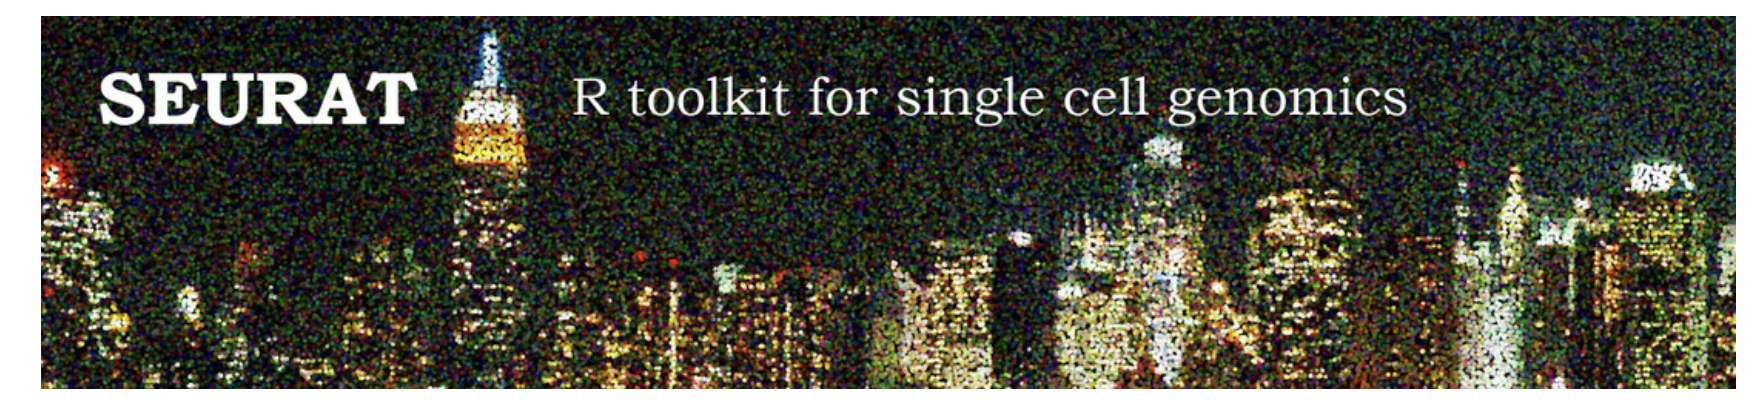

* Both very capable frameworks
* Python vs R & their ecosystems
* R/Seurat is better for advanced statistics, **differential expression** analysis

## Where to get data?

There are many sources to get single cell data from.

- Generate yourself
- GEO / SRA - see for example [the GEO page for our paper](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE127893)
- https://cellxgene.cziscience.com/datasets

## Experimental setup

* Sample selection
* Single cells or nuclei?
* Cell/nuclei Isolation protocol


# Before we start

## Importing modules

In [14]:
import scanpy as sc
import pandas as pd
import seaborn as sns

---

---

# Finding & loading data

A **raw count** matrix & **cell metadata** table are provided as `counts.tsv.gz` and `metadata.tsv.gz`. There are gzipped (compressed) tab-separated text files.

## Metadata.

The experiment compares microglia from mice multiple ages (3, 6, 12 and 21 months); from male and female mice; from hippocampus and cortex; and from wild-type mice and APP-NLGF AD model mice. The metadata fields are encoded as:

| Field          |                  |                    |
|:---------------|:-----------------|:-------------------|
| **gender**     | **F**: Female    | **M**: Male        |
| **genotypep**  | **K**: APP-NLGF  | **W**: Wild type   |
| **tissue**     | **C**: Cortex    | **H**: Hippocampus |


## Actually load the data

In [206]:
# load raw counts using pandas' `read_csv` function
counts = pd.read_csv('counts.tsv.gz', sep="\t", index_col=0)
counts.shape

(10801, 29474)

In [193]:
# load metadata
metadata = pd.read_csv('metadata.tsv.gz', sep="\t", index_col=0)
metadata.shape

(10801, 6)

## Inspect your data!

Very important - never blindly rely on data being what you think it is

In [194]:
counts.iloc[:5,:5]

-343C11.2  00R_AC107638.2  0610005C13Rik  0610006L08Rik  \
K03FC.1A10          0               0              0              0   
K03FC.3A6           0               0              0              0   
K03FH.3B1           0               0              0              0   
K03FH.3E3           0               0              0              0   
K03FH.4A11          0               0              0              0   

            0610007P14Rik  
K03FC.1A10              0  
K03FC.3A6               0  
K03FH.3B1               0  
K03FH.3E3               0  
K03FH.4A11              0

This is an awful lot of zero's. A cell can be zero if a gene does not express in that cell - or - if for whatever reason the gene is not picked up. Single cell transcriptomics, compared to bulk transcriptomics has to work with very little RNA - and hence - it's sensitivity is much lower. In this dataset ~93% is zero, which is not abnormal and explains the large number of zero's in the snippet above (in bulk RNAseq I would expect that to be well below 50%)

Let's see some gene/cells that do express. First question - what is a highly expressing gene?

In [219]:
# note the power of pandas by chaining operations:
# first we sum per gene, then sort descendingly, and show the 'head'
counts.sum().sort_values(ascending=False).head()

Rn18s-rs5    269069792
Cst3         257752441
Hexb          92712398
Ctss          82061674
Cx3cr1        77511440
dtype: int64

And check the values of a few top genes
it pays off to have a few favourite genes, I'm adding "Apoe".

In [ ]:
counts[ ['Cst3', 'Hexb', 'Ctss', 'Apoe'] ].head()

Cst3  Hexb  Ctss  Apoe
K03FC.1A10  6630  2134  3327     1
K03FC.3A6   7155    74  1131     0
K03FH.3B1   4601  2459  2507     0
K03FH.3E3    853   589   552     0
K03FH.4A11  3944  1426  1701     0

Note, these are all integers - as you would expect dealing with raw counts.

In [205]:
metadata.head()

age gender genotype tissue  plate     lane
K03FC.1A10    3      F        K      C      1  mglia25
K03FC.3A6     3      F        K      C      3  mglia26
K03FH.3B1     3      F        K      H      3  mglia28
K03FH.3E3     3      F        K      H      3  mglia28
K03FH.4A11    3      F        K      H      4  mglia28

## <span style="color:crimson">🏃 Exercise</span>

---

# Preprocessing & QA

---

# Dimensionality reduction & clustering

---

# Differential expression, finding marker genes

---

# Continuing the analysis

---

# Closing remarks

---

In [67]:
adata.obs['age.genotype'].value_counts()

age.genotype
6W     1421
12W    1365
3W     1362
6K     1358
3K     1343
12K    1340
21W    1314
21K    1298
Name: count, dtype: int64

In [80]:
adata.shape

(10801, 29341)

In [79]:
del adata.raw

(10801, 29341)

In [103]:
adata.write_h5ad('SalaFrigerio_finished.h5ad')

In [141]:
adata.obs_names[:4]

Index(['K03FC.1A10', 'K03FC.3A6', 'K03FH.3B1', 'K03FH.3E3'], dtype='object')

((10801, 29474), (10801, 29341))

In [149]:
raw = pd.read_csv('mad.microglia.all.raw.tsv.gz', sep="\t", index_col=0)
raw.shape

(29474, 12680)

In [150]:
raw2 = raw[adata.obs_names]
raw2.shape

(29474, 10801)

In [151]:
adata.shape

(10801, 29341)

In [154]:
adata2 = sc.AnnData(raw2.T, obs=adata.obs)

In [155]:
adata2.obs

percent.mito  age gender genotype tissue plateplus  plate  \
K03FC.1A10      0.057330    3      F        K      C   K03FCp1      1   
K03FC.3A6       0.037483    3      F        K      C   K03FCp3      3   
K03FH.3B1       0.013558    3      F        K      H   K03FHp3      3   
K03FH.3E3       0.027401    3      F        K      H   K03FHp3      3   
K03FH.4A11      0.031306    3      F        K      H   K03FHp4      4   
...                  ...  ...    ...      ...    ...       ...    ...   
W21FH.4E12      0.015020   21      F        W      H   W21FHp4      4   
W21FH.4E5       0.025329   21      F        W      H   W21FHp4      4   
W21FH.4E6       0.013109   21      F        W      H   W21FHp4      4   
W21FH.4H12      0.018136   21      F        W      H   W21FHp4      4   
W21FH.4H1       0.026894   21      F        W      H   W21FHp4      4   

               lane    set    reads  ...  SalaFrigerio_ARM  SalaFrigerio_IRM  \
K03FC.1A10  mglia25  K03FC   350758  ...         -0.046302         -0.053802   
K03FC.3A6   mglia26  K03FC   274496  ...          0.021723          0.019220   
K03FH.3B1   mglia28  K03FH   421608  ...         -0.071629         -0.065560   
K03FH.3E3   mglia28  K03FH   216563  ...         -0.127054         -0.073534   
K03FH.4A11  mglia28  K03FH   326897  ...         -0.027898         -0.063858   
...             ...    ...      ...  ...               ...               ...   
W21FH.4E12  mglia22  W21FH  1055910  ...          0.200995          0.009922   
W21FH.4E5   mglia22  W21FH   885793  ...          0.393193          0.142878   
W21FH.4E6   mglia22  W21FH   834076  ...          0.176524          0.176780   
W21FH.4H12  mglia22  W21FH  1027120  ...          0.215861          0.093035   
W21FH.4H1   mglia22  W21FH   511312  ...          0.117471         -0.032410   

            SalaFrigerio_TRM  Pseudotime  age.genotype  cell.state  \
K03FC.1A10          0.345285    0.392767            3K         H1M   
K03FC.3A6           0.312553    0.452833            3K         H1M   
K03FH.3B1           0.265650    0.329653            3K         H1M   
K03FH.3E3           0.121577    0.000000            3K         H1M   
K03FH.4A11          0.347746    0.247774            3K         H1M   
...                      ...         ...           ...         ...   
W21FH.4E12          0.528972    0.585543           21W         H1M   
W21FH.4E5           0.921011    7.437296           21W         H1M   
W21FH.4E6           0.559907    0.941934           21W         H1M   
W21FH.4H12          0.538021    4.131379           21W         H1M   
W21FH.4H1           0.629423    1.261238           21W         H1M   

            n_genes_by_counts  total_counts  total_counts_mt  pct_counts_mt  
K03FC.1A10              29300  -1094.560149       -13.126001       1.199203  
K03FC.3A6               29300   -722.021893        -4.700211       0.650979  
K03FH.3B1               29300   -861.431630        -6.355747       0.737812  
K03FH.3E3               29300   -843.189251        -0.441689       0.052383  
K03FH.4A11              29300   -568.249506        -2.360772       0.415446  
...                       ...           ...              ...            ...  
W21FH.4E12              29300    105.305872         3.123063       2.965707  
W21FH.4E5               29300    136.600294        -0.545587      -0.399404  
W21FH.4E6               29300   -104.665000         1.994412      -1.905520  
W21FH.4H12              29300    -76.306157        -2.923237       3.830932  
W21FH.4H1               29300   -347.844955        -1.144697       0.329082  

[10801 rows x 33 columns]

In [157]:
raw2.T.to_csv('counts.tsv.gz', sep="\t")

In [160]:
raw2.iloc[:4,:4]

K03FC.1A10  K03FC.3A6  K03FH.3B1  K03FH.3E3
-343C11.2                0          0          0          0
00R_AC107638.2           0          0          0          0
0610005C13Rik            0          0          0          0
0610006L08Rik            0          0          0          0

In [162]:
print('\t'.join(adata.obs.columns))

percent.mito	age	gender	genotype	tissue	plateplus	plate	lane	set	reads	genes	pcmito	log2reads	log2genes	z_neutrop	Friedman_Interferon	Friedman_LPS	Friedman_Macrophage	Friedman_Microglia	Friedman_Neurodegeneration	Friedman_Neutrophil_Monocyte	Friedman_Proliferation	SalaFrigerio_HM	SalaFrigerio_ARM	SalaFrigerio_IRM	SalaFrigerio_TRM	Pseudotime	age.genotype	cell.state	n_genes_by_counts	total_counts	total_counts_mt	pct_counts_mt


In [189]:
meta2 = adata.obs.loc[raw2.columns][
    'age gender genotype tissue plate lane'.split()]


**gender**

 - F - Female
 - M - Male
  
**genotypep**

 - K - APP-NLGF
 - W - Wild tye
  
**tissue**

 - C - Cortex
 - H - Hippocampus
    

In [196]:
meta2.head()

age gender genotype tissue  plate     lane
K03FC.1A10    3      F        K      C      1  mglia25
K03FC.3A6     3      F        K      C      3  mglia26
K03FH.3B1     3      F        K      H      3  mglia28
K03FH.3E3     3      F        K      H      3  mglia28
K03FH.4A11    3      F        K      H      4  mglia28

In [197]:
meta2.to_csv('metadata.tsv.gz', sep="\t")

In [204]:
!zcat metadata.tsv.gz

zcat: can't stat: metadata.tsv.gz (metadata.tsv.gz.Z): No such file or directory


In [191]:
meta2.head()

age gender genotype tissue  plate     lane
K03FC.1A10    3      F        K      C      1  mglia25
K03FC.3A6     3      F        K      C      3  mglia26
K03FH.3B1     3      F        K      H      3  mglia28
K03FH.3E3     3      F        K      H      3  mglia28
K03FH.4A11    3      F        K      H      4  mglia28

In [112]:
adata.obs['genotype'].value_counts()

genotype
W    5462
K    5339
Name: count, dtype: int64

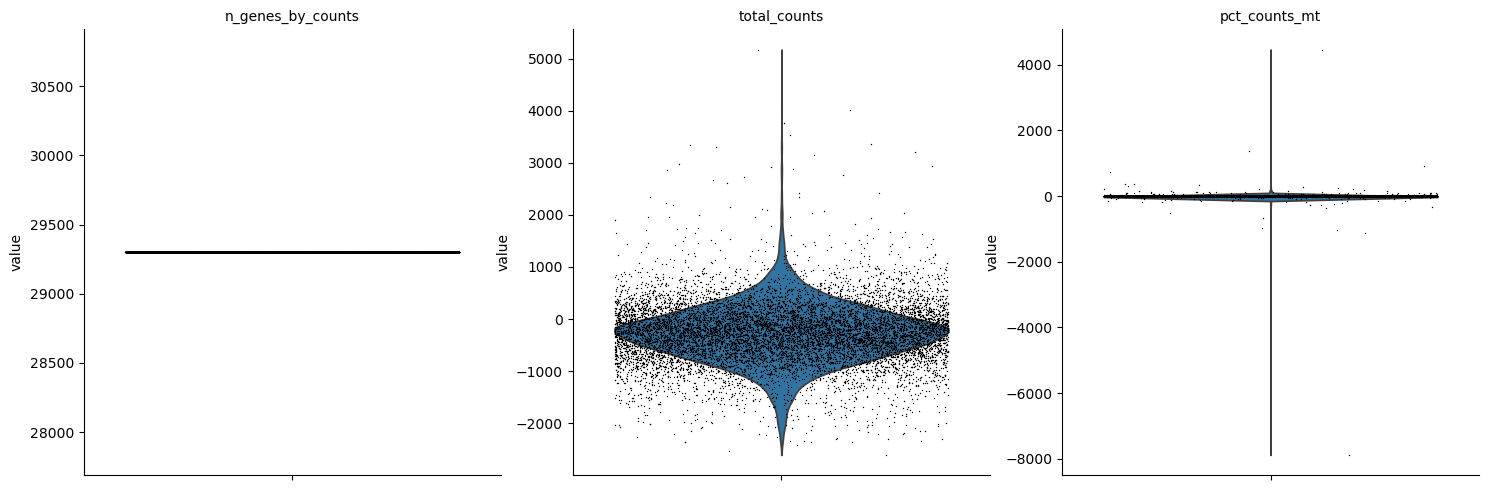

In [115]:
adata.var["mt"] = adata.var_names.str.upper().str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)


In [137]:
meta = pd.DataFrame(index = raw.columns)
meta['genotype'] = meta.index.str[0]
meta['age'] = meta.index.to_series().str[1:3].astype(int).replace({17:18})
meta['genotype'] = meta.index.str[0]
meta['tissue'] = meta.index.to_series().str[4].replace({'C': "Cortex", 'H': 'Hippocampus'})

#meta[
print(meta.head())
print(meta.index.to_series().sample(10))
meta.index.to_series().str[4].replace({'C': "Cortex", 'H': 'Hippocampus'}).value_counts()

           genotype  age  tissue
C18MC.1A11        C   18  Cortex
C18MC.1A12        C   18  Cortex
C18MC.1B11        C   18  Cortex
C18MC.1B12        C   18  Cortex
C18MC.1B2         C   18  Cortex
D18MH.2D10    D18MH.2D10
D18MH.3F6      D18MH.3F6
K06FC.2F1      K06FC.2F1
C18MC.2C5      C18MC.2C5
K06FC.3A10    K06FC.3A10
K03MC.1E9      K03MC.1E9
W06FH.1H6      W06FH.1H6
K06FH.2E1      K06FH.2E1
W03FC.3A10    W03FC.3A10
D18MH.4D6      D18MH.4D6
dtype: object


Cortex         6599
Hippocampus    6081
Name: count, dtype: int64

---

# Prepare

In [65]:
adata.obs.head(2).T

K03FC.1A10  K03FC.3A6
percent.mito                    0.05733   0.037483
age                                   3          3
gender                                F          F
genotype                              K          K
tissue                                C          C
plateplus                       K03FCp1    K03FCp3
plate                                 1          3
lane                            mglia25    mglia26
set                               K03FC      K03FC
reads                            350758     274496
genes                              1799       2106
pcmito                         5.733013   3.748324
log2reads                     18.420116  18.066426
log2genes                     10.812979   11.04029
z_neutrop                     -0.189519  -0.181471
Friedman_Interferon             0.02771   0.034963
Friedman_LPS                  -0.029528  -0.057439
Friedman_Macrophage           -0.018148   0.136754
Friedman_Microglia             1.328413   1.321726
Friedman_Neurodegeneration    -0.068558  -0.057586
Friedman_Neutrophil_Monocyte  -0.033021  -0.022006
Friedman_Proliferation        -0.018989  -0.004348
SalaFrigerio_HM                0.940508   0.945475
SalaFrigerio_ARM              -0.046302   0.021723
SalaFrigerio_IRM              -0.053802    0.01922
SalaFrigerio_TRM               0.345285   0.312553
Pseudotime                     0.392767   0.452833
age.genotype                         3K         3K
cell.state                          H1M        H1M

In [23]:
adata = sc.read_h5ad('salafrigerio.h5ad')
adata.obsm['X_trajectory'] = adata.obs[['traj_1', 'traj_2']].values

del adata.obs['traj_1']
del adata.obs['traj_2']


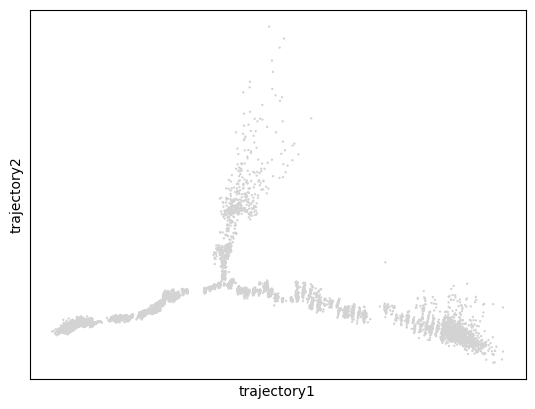

In [24]:
sc.pl.embedding(adata, basis='trajectory')

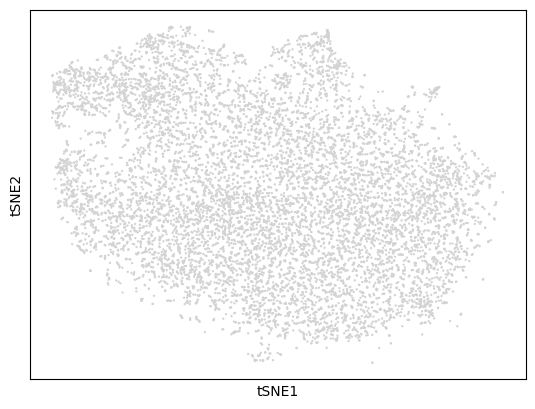

In [25]:
sc.pl.tsne(adata)